# Actual Model

### Step-1: Importing the relevant libraries and data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from pylab import bone, pcolor, colorbar, plot, show, rcParams
from plotly.offline import download_plotlyjs
from plotly.offline import init_notebook_mode
from plotly.offline import plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.graph_objs as go

In [2]:
#Importing the CSV file
hdi = pd.read_csv('hdro.csv')
hdi.head(3)

,Country,CODE,Fossil_fuel_usage,Renewable_energy_usage,Per_capita_CO2,Forest_area,change_in_forest_area,fresh_water_withdrawl,natural_resource_reduction,air_pollution_deaths_per_100000,water_related_deaths_per_100000,land_degradation,red_list_index,Pollution Index
0,Norway,NOR,57.0,57.8,6.8,33.2,-0.1,0.8,4.4,9,0.2,..,0.940,20.29
1,Switzerland,CHE,50.2,25.3,4.5,31.8,9.3,3.8,0.0,10,0.1,..,0.974,21.31
2,Ireland,IRL,85.3,9.1,7.9,11.0,63.4,1.5,0.1,12,0.1,..,0.925,33.02


In [3]:
hdi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 14 columns):
Country                            190 non-null object
CODE                               187 non-null object
Fossil_fuel_usage                  190 non-null object
Renewable_energy_usage             190 non-null float64
Per_capita_CO2                     190 non-null object
Forest_area                        190 non-null object
change_in_forest_area              190 non-null object
fresh_water_withdrawl              190 non-null object
natural_resource_reduction         190 non-null object
air_pollution_deaths_per_100000    190 non-null object
water_related_deaths_per_100000    190 non-null object
land_degradation                   190 non-null object
red_list_index                     190 non-null float64
Pollution Index                    103 non-null float64
dtypes: float64(3), object(11)
memory usage: 20.9+ KB


##### There are few problems with our data. Except for Country and CODE columns, all of the other columns should be float. There are missing values in CODE and Pollution Index columns. We will try to fix these problems in Data Cleaning process.

### Step-2: Data Cleaning

In [4]:
# Cleaning the columns that have ".." in place of null values
for i in range(len(hdi.columns)):
    hdi.ix[hdi.ix[:,i] == '..', i] = 0
    
# Converting the datatype of columns to float
for column in hdi.columns:
    if column not in ['Country', 'CODE'] :
        hdi[column] = hdi[column].astype(float)

# Assigning zero to null values in columns 'Pollution Index'
hdi['Pollution Index'].fillna(0,inplace=True)

/Users/ravidahiya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/Users/ravidahiya/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



### Step-3 Data Visualisation

As our primary objective is to let the SOMs organise countries on the basis of the data provided. We will not be using advanced plots. However, we will plot barplot of all the parameters against country CODE.

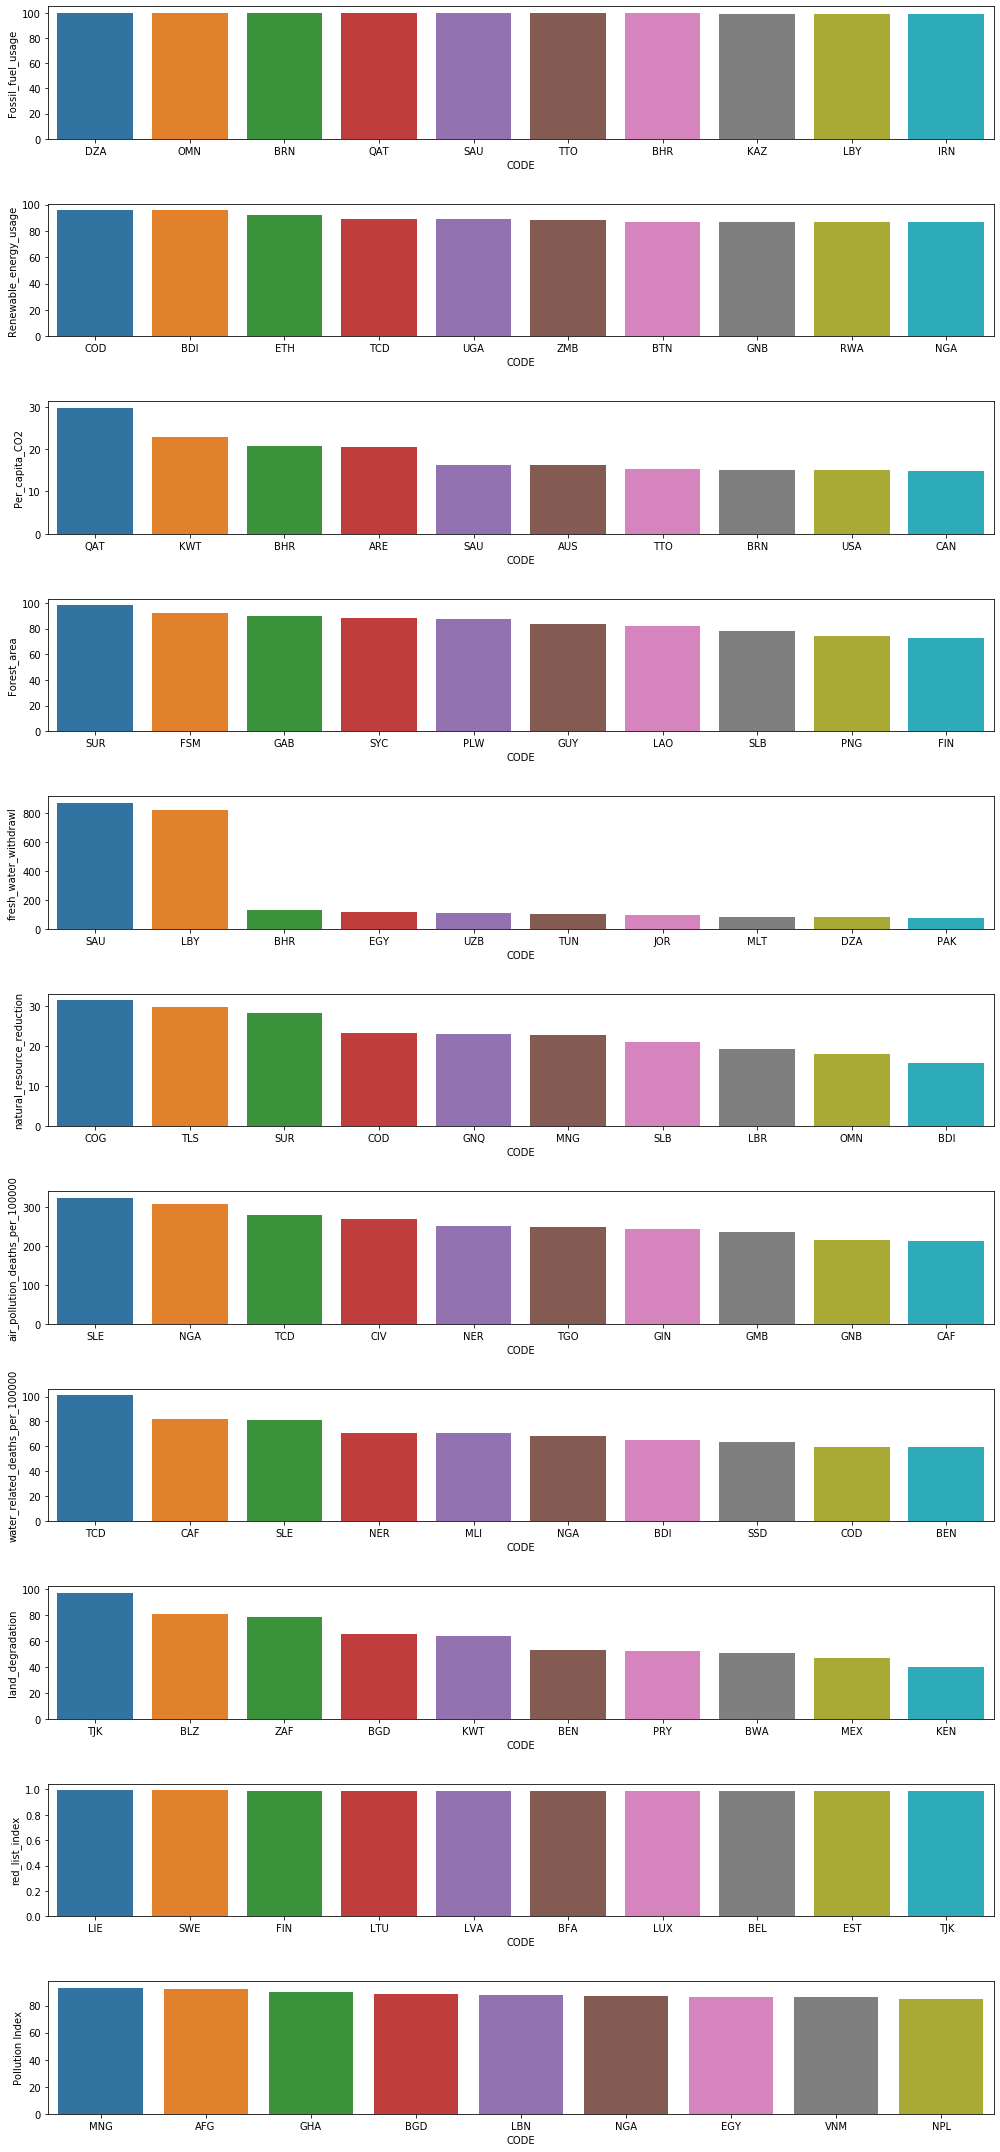

In [5]:
fig,ax = plt.subplots(11, figsize=(14,30))
columns = ['Fossil_fuel_usage', 'Renewable_energy_usage',
       'Per_capita_CO2', 'Forest_area', 'fresh_water_withdrawl',
       'natural_resource_reduction', 'air_pollution_deaths_per_100000',
       'water_related_deaths_per_100000', 'land_degradation', 'red_list_index',
       'Pollution Index']
for i in range(11):
    sns.barplot(x='CODE',y= columns[i], data=hdi.sort_values(columns[i],ascending=False).head(10), ax=ax[i])
plt.tight_layout()
plt.show()

       As we can see from the plots Middle east, African countries and few countries in Asia are not performing 
       well on the parameters under observation. 

### Step-4 Building the SOM model

We will be using the minisom library developed by ['JustGlowing']('https://github.com/JustGlowing/minisom')

In [6]:
# Applying min max scaling to all the columns except Country & CODE 
sc = MinMaxScaler()
X = sc.fit_transform(hdi.drop(['Country', 'CODE'],axis=1))

In [7]:
#Building a 2-D matrix
som = MiniSom(12,12,X.shape[1])

#Assigning random initial weights
som.random_weights_init(X)

#Training the model with 100 epochs
som.train_random(X,100)

### Step-5: Visualising the results

'SOM' assigns each row to a node seperated by another node by a certain [Euclidean Distance]("https://en.wikipedia.org/wiki/Euclidean_distance"). So, we will plot heatmap of the Euclidean Distances to identify similar and dissimilar nodes. Higher the Euclidean Distance, larger is the dissimilarity between two nodes.

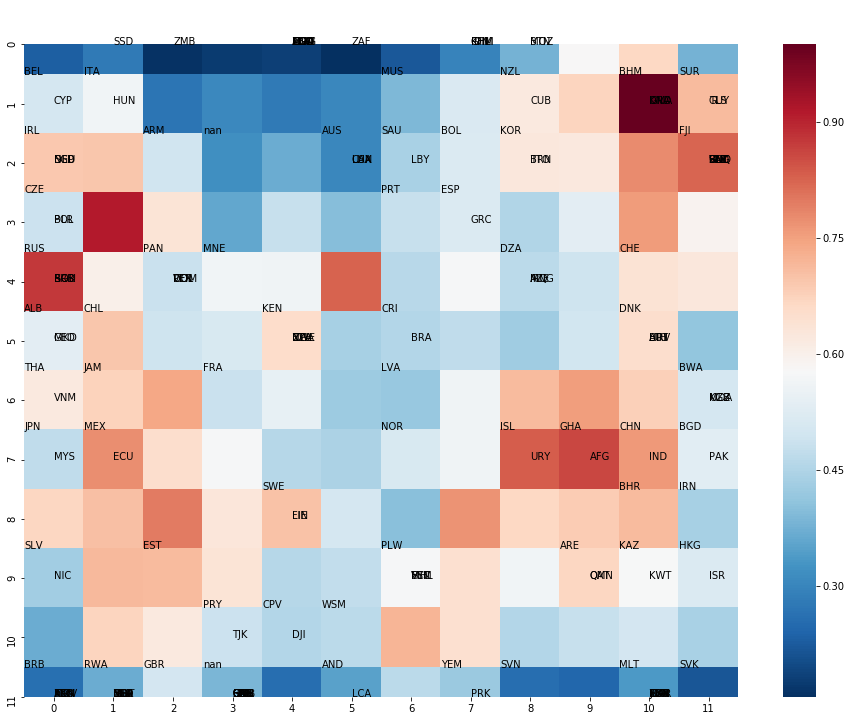

In [8]:
plt.figure(figsize=(16,12))
temp_w1 = []
temp_w2 = []
sns.heatmap(som.distance_map(), cmap='RdBu_r')
for i, x in enumerate(X):
    w = som.winner(x)
    if w not in temp_w1 :
        plt.annotate(hdi['CODE'][i],(w[0],w[1]))
        temp_w1.append(w)
    else:
        plt.annotate(hdi['CODE'][i],(w[0]+0.5,w[1]+0.5))
    

##### As we can see that the countries are classified and allocated a node on the basis of how similar they are. We will now plot these results using choropleth maps to better understand the situation

In [9]:
# Extracting the distance map and allocating the score to the country
dist_map = som.distance_map()
w=[]
for x in X:
    w.append(som.winner(x))
countries = {}
for i in range(len(w)):
    countries[i] = dist_map[w[i]]
countries = pd.DataFrame(data = countries.values(), index= countries.keys(), columns = ['Indicator'])

#Creating Dataframe to be used for chropleth map
countries = hdi.join(countries)[['Country', 'CODE','Indicator']]

In [10]:
# Data dict
data = dict(
        type = 'choropleth',
        locations = countries['CODE'],
        z = 1- countries['Indicator'],
        text = countries['Country'], 
        colorbar = {'title' : 'Environmental Performance'},
        colorscale="Earth"
      )

# Layout
layout = dict(
    title = 'World Environment Sustainability-2018',
    geo = dict(
        showframe = False, 
        projection = {'type':'equirectangular'}
    )
)

#Finally plotting
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

### Results

As we can see that environmental performance is lowest among countries like India, Pakistan, Nigeria, Yemen, Saudi Arabia, Congo and other African countries. Countries like Canada, US, Brazil, Australia and West Europian countries are perfoming well on the sustainability index. We can compare the results wit the Enviormental Performance Index we see that our model produces similar results.
<img src="images\image2.png">